In [1]:
import torch
from matplotlib import pyplot as plt

In [2]:
Xb =  torch.tensor([[1.,2.,3.],[4.,5.,6.], [7.,8.,9.]])
Xq  = torch.tensor([[4.,5.,6.], [10., 11. , 12.], [13., 14. , 15.], [16., 17. , 18.]])

In [3]:
Xq, Xb

(tensor([[ 4.,  5.,  6.],
         [10., 11., 12.],
         [13., 14., 15.],
         [16., 17., 18.]]),
 tensor([[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]))

In [4]:
Xq.shape, Xb.shape

(torch.Size([4, 3]), torch.Size([3, 3]))

In [5]:
# simple double loop for unit test
def ground_truth(Xq, Xb):
    distances = torch.zeros((Xq.shape[0],Xb.shape[0]))
    for i in range(len(Xq)):
        for j in range(len(Xb)):
            x = Xq[i]
            y = Xb[j]
            distances[i,j] = (x-y).square().sum()
    return distances

In [6]:
ground_truth(Xq, Xb)

tensor([[ 27.,   0.,  27.],
        [243., 108.,  27.],
        [432., 243., 108.],
        [675., 432., 243.]])

In [7]:
ground_truth(Xb, Xq)

tensor([[ 27., 243., 432., 675.],
        [  0., 108., 243., 432.],
        [ 27.,  27., 108., 243.]])

In [8]:
Xq[:, None, :].shape, Xb.shape

(torch.Size([4, 1, 3]), torch.Size([3, 3]))

In [9]:
print(Xq[:, None, :].shape) # being explicit here but can be written as Xq[:, None]
print(Xb[None,:, :].shape)  # being explicit here but can be written as Xb[None]

torch.Size([4, 1, 3])
torch.Size([1, 3, 3])


In [10]:
assert torch.equal(Xq[:, None, :] , Xq[:,None])
assert torch.equal(Xb[None,:, :] , Xb[None])

In [11]:
Xq[:,None].shape, Xb[None].shape

(torch.Size([4, 1, 3]), torch.Size([1, 3, 3]))

In [12]:
(Xq[:, None] - Xb[None]).shape

torch.Size([4, 3, 3])

In [13]:
(Xq[:, None] - Xb[None]).square().sum(2)

tensor([[ 27.,   0.,  27.],
        [243., 108.,  27.],
        [432., 243., 108.],
        [675., 432., 243.]])

In [14]:
assert torch.equal(ground_truth(Xq, Xb), (Xq[:, None] - Xb[None]).square().sum(2))

In [15]:
assert torch.equal(ground_truth(Xb, Xq), (Xb[:, None] - Xq[None]).square().sum(2))

In [16]:
# broadcasted version of squared Euclidean distance
def square_distance(Xb, Xq):
    return (Xb[:, None] - Xq[None]).square().sum(2)

Create Some Fake Cluster Data

In [17]:
from sklearn.datasets import make_blobs

n_samples = 1000000
k = 15
X, y_true = make_blobs(
    n_samples=n_samples, centers=k, cluster_std=0.3, random_state=42
)
X = X[:, ::-1]

In [18]:
# get torch tensor
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
data = torch.tensor(X.copy()).to(device)
data.device

device(type='cuda', index=0)

In [19]:
data.shape

torch.Size([1000000, 2])

In [20]:
import numpy as np

def plot_data(centroids, nsample=1000, save=None):
    fig = plt.figure()
    ax = fig.add_subplot()
    for cluster in range(k):
        cluster_data = y_true == cluster
        ax.scatter(X[cluster_data, 0][:nsample], X[cluster_data, 1][:nsample], marker=".", s=1, zorder=0)
    for centroid in centroids.cpu():
        ax.scatter(centroid[0], centroid[1], marker="*", s=100, zorder=1, color='black')
    if save is not None:
        plt.savefig(f'{save}.png')
    plt.show()

Initialization of Centroids

Random Initialization

For kmeans to work well we need a good random initialization for the centroids.

One option is to choose 'k' random points from the dataset. Run this cell multiple times to see that this method is quite volatile. Often the initially random selected centroids will be from the same cluster.

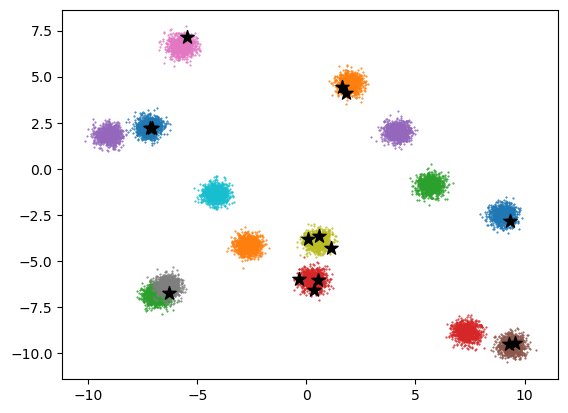

In [21]:
centroids = data[torch.randint(0, len(data), (k,))].to(device) # this random initialization method is not very good!
plot_data(centroids)

kmeans++ is a better initialization method. The idea is to spread out the initial centroids as much as possible.

pick a centroid at random from the dataset.
compute the distance between each data point and the centroid.
sample another point from the dataset in such a way that a point that is further away from the first centroid has a higher probability of being selected. Now there are two centroids selected.
Now compute the distance between each point and the nearest centroid. Similarly, pick another point randomly from the dataset using weighted random sampling (based on the distance from the data point to the nearest centroid).
Continue until you have 'k' centroids.

In [22]:
centroids = data[torch.randint(0, len(data), (1,))].to(device) # pick first point at random

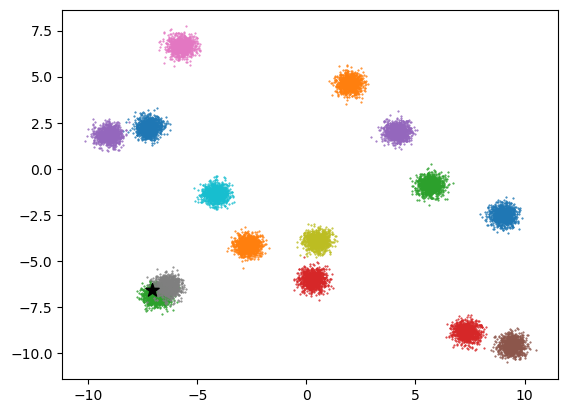

In [24]:
plot_data(centroids)

In [25]:
dists_to_centroids = square_distance(data, centroids)
dists_to_centroids = dists_to_centroids.min(dim=1)[0] # get the distance to nearest centroid
weights = (dists_to_centroids / dists_to_centroids.max().square())
weights, weights.device

(tensor([1.0864e-06, 6.7137e-04, 1.7525e-03,  ..., 1.8544e-03, 2.6839e-03,
         1.8918e-03], device='cuda:0', dtype=torch.float64),
 device(type='cuda', index=0))

In [26]:
from torch.utils.data import WeightedRandomSampler

In [27]:
centroid_idx = list(WeightedRandomSampler(weights, 1, replacement=False))[0]
centroid_idx

648834

In [28]:
centroids = torch.vstack([centroids, data[centroid_idx]])

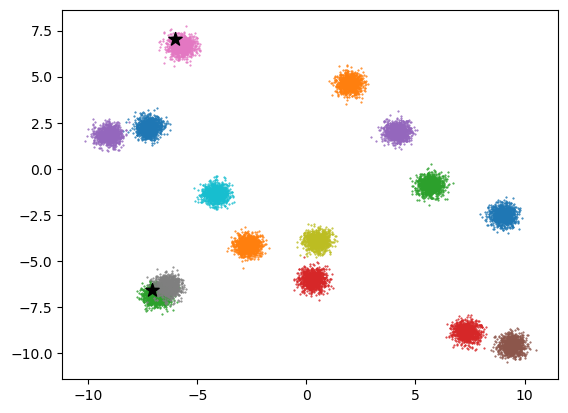

In [30]:
plot_data(centroids)

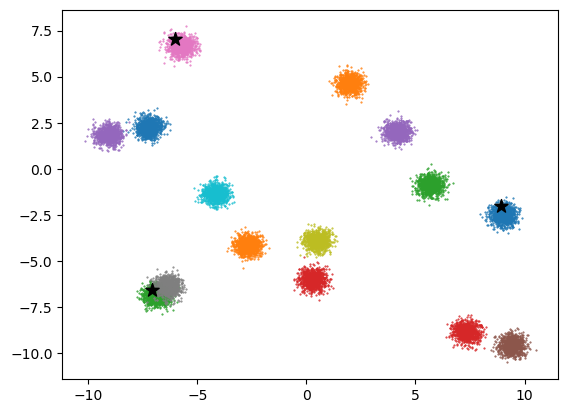

In [31]:
dists_to_centroids = square_distance(data, centroids)
dists_to_centroids = dists_to_centroids.min(dim=1)[0] # get the distance to nearest
weights = (dists_to_centroids / dists_to_centroids.max().square())
centroid_idx = list(WeightedRandomSampler(weights, 1, replacement=False))[0]
centroids = torch.vstack([centroids, data[centroid_idx]])
plot_data(centroids)

And so on...

Lets wrap the logic for initialization in a single function:



In [32]:
def initialize_centroids(data, k):
    centroids = data[torch.randint(0, len(data), (1,))] # pick first point at random
    
    for i in range(k-1): # pick remaining centroids
        dists_to_centroids = square_distance(data, centroids)
        dists_to_centroids = dists_to_centroids.min(dim=1)[0] # get the distance to nearest
        weights = (dists_to_centroids / dists_to_centroids.max().square())
        centroid_idx = list(WeightedRandomSampler(weights, 1, replacement=False))[0]
        centroids = torch.vstack([centroids, data[centroid_idx]])
    
    return centroids
    

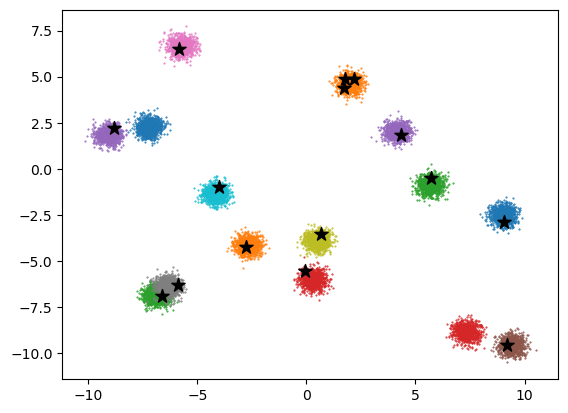

In [33]:
centroids = initialize_centroids(data, k)
plot_data(centroids)

Iterations for Updating Centroids

Now we have the initial centroids selected. Next we proceed with the kmeans implementation:

- compute distances between data points and centroids
- map each data point to nearest centroid
- update centroids based on the data points in each cluster
- repeat until it stabilizes

Lets go through one iteration here to show how it works.



In [34]:
dists = square_distance(data, centroids)
dists # torch.Size([N, k]) holds the distance between each data point and each centroid

tensor([[2.5243e+01, 2.6875e+02, 1.3283e-01,  ..., 2.0372e+02, 2.1560e+02,
         1.5961e+00],
        [7.8460e+01, 4.7276e+02, 7.7819e+01,  ..., 1.3611e+02, 1.4038e+02,
         7.2979e+01],
        [7.4467e+01, 9.3028e+01, 1.7644e+02,  ..., 3.9215e+01, 4.4008e+01,
         1.5260e+02],
        ...,
        [1.4417e+02, 5.1796e+02, 2.0223e+02,  ..., 6.8867e+01, 6.7174e+01,
         1.8508e+02],
        [1.7856e+02, 1.1969e-01, 2.6458e+02,  ..., 2.6259e+02, 2.7552e+02,
         2.4557e+02],
        [8.3955e+01, 9.0566e+01, 1.9061e+02,  ..., 4.2338e+01, 4.6988e+01,
         1.6586e+02]], device='cuda:0', dtype=torch.float64)

In [35]:
assigned_clusters = torch.argmin(dists, dim=1) # pick the centroid with the smallest distance
print(assigned_clusters.shape)
assigned_clusters

torch.Size([1000000])


tensor([ 2,  5, 10,  ...,  8,  1, 10], device='cuda:0')

In [36]:
# update the centroids by taking the centroid of each cluster
for j in range(k): # TODO how to do without a for loop
    centroids[j] = data[assigned_clusters == j].mean(dim=0)
centroids

tensor([[-2.6715, -4.1561],
        [ 8.3606, -9.2136],
        [-6.7991, -6.7952],
        [ 4.1614,  2.0219],
        [ 9.0134, -2.5075],
        [-8.1405,  2.0427],
        [ 0.2846, -5.9833],
        [-4.1773, -1.3638],
        [-5.7535,  6.6465],
        [ 2.2479,  4.7445],
        [ 5.7040, -0.8801],
        [ 0.4993, -3.9028],
        [ 1.8445,  4.3674],
        [ 1.7488,  4.8767],
        [-6.1935, -6.2529]], device='cuda:0', dtype=torch.float64)

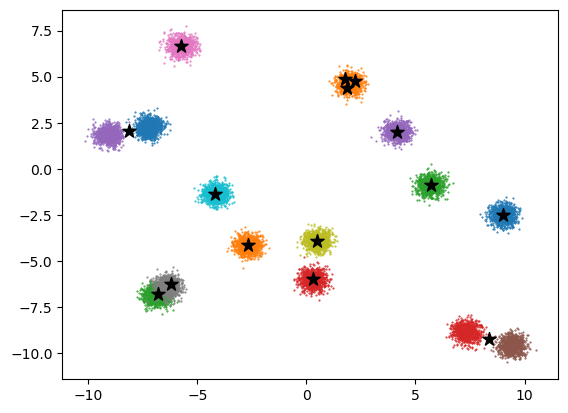

In [37]:
plot_data(centroids)

Okay, lets wrap it all up in one function.



In [38]:
def kmeans(data, k, iterations=10, init_method=None):        
    # initialize centroids
    if init_method == 'simple':
        centroids = data[torch.randint(0, len(data), (k,))] # this random initialization method is not very good!
    else:
        centroids = initialize_centroids(data, k)
    data = data
    
    if iterations == 0:
        # for debug and showing initialization without any updates
        dists = square_distance(data, centroids)
        assigned_clusters = torch.argmin(dists, dim=1)
        return centroids, assigned_clusters
        
    # update centroids though iteration
    for i in range(iterations):
        dists = square_distance(data, centroids)
        assigned_clusters = torch.argmin(dists, dim=1)
        
        for j in range(k): # TODO how to do without a for loop
            centroids[j] = data[assigned_clusters == j].mean(dim=0)
    return centroids, assigned_clusters


0.8799238204956055


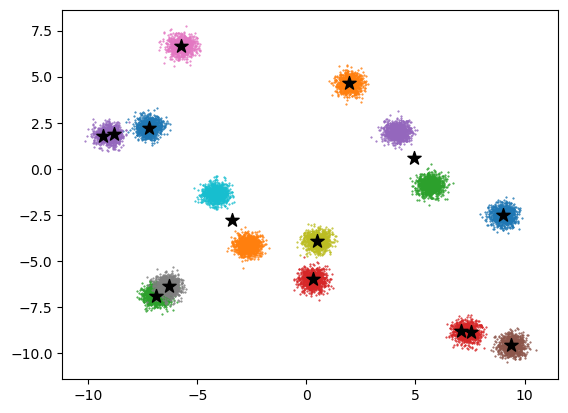

In [39]:
# random simple initialization
import time
ct = time.time()
torch.manual_seed(53532)
centroids, assigned_clusters = kmeans(data, k, 100, init_method='simple') 
print(time.time() - ct)
plot_data(centroids)

0.9319219589233398


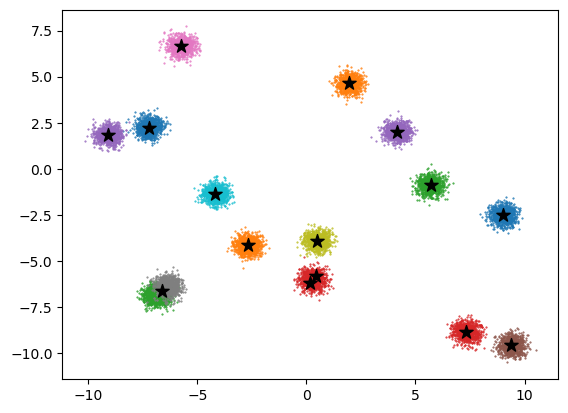

In [40]:
# better spread out initalization
ct = time.time()
torch.manual_seed(53532)
centroids, assigned_clusters = kmeans(data, k, 100)
print(time.time() - ct)
plot_data(centroids)

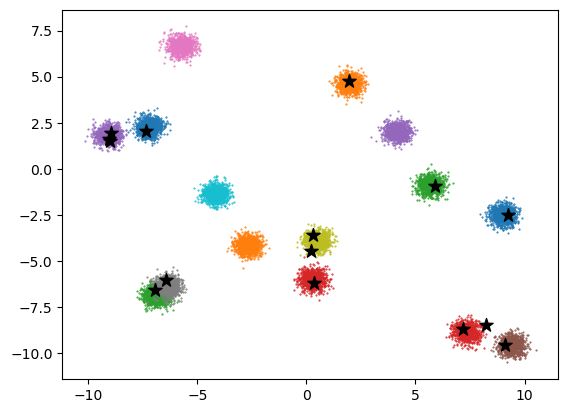

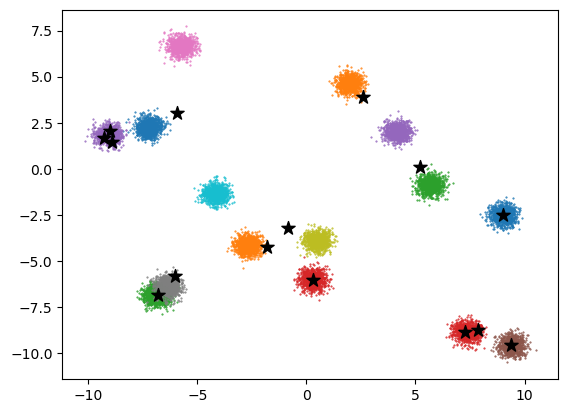

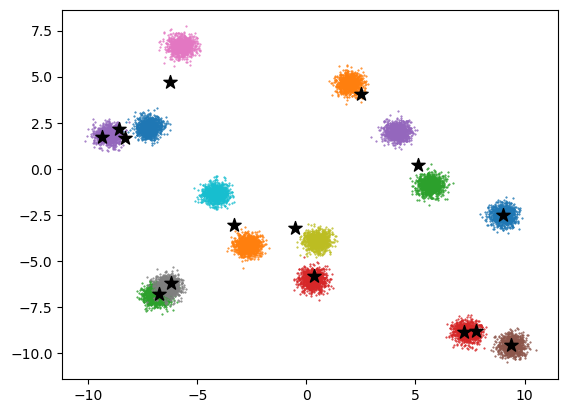

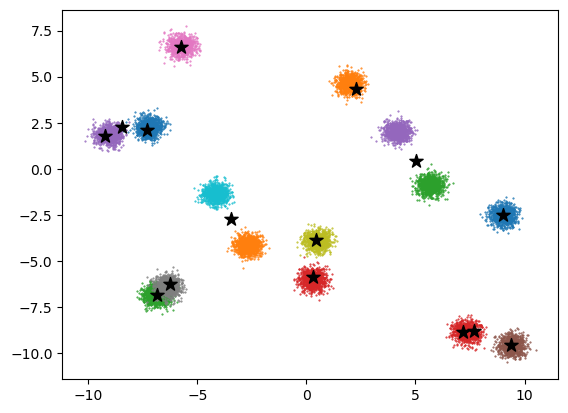

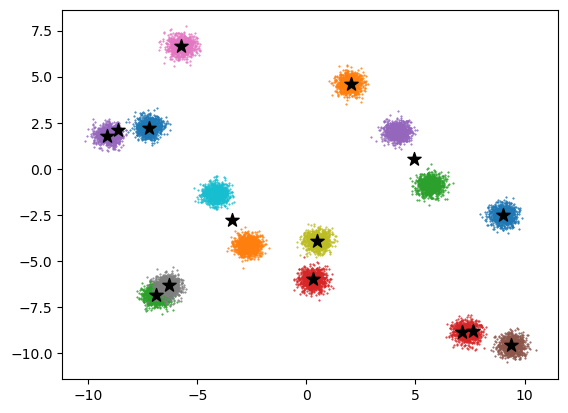

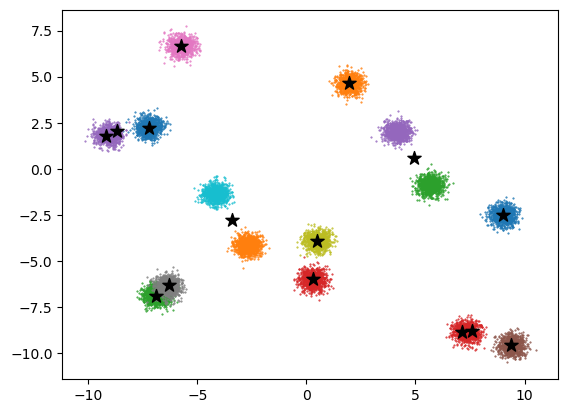

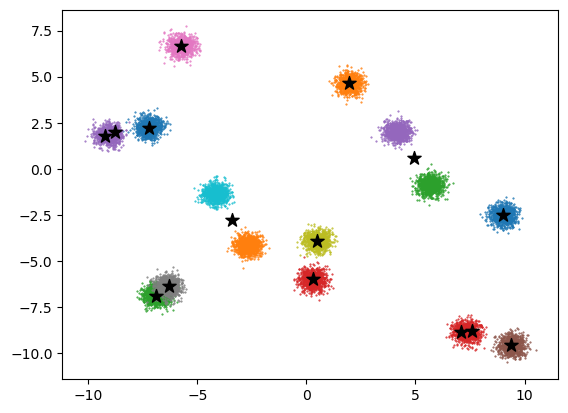

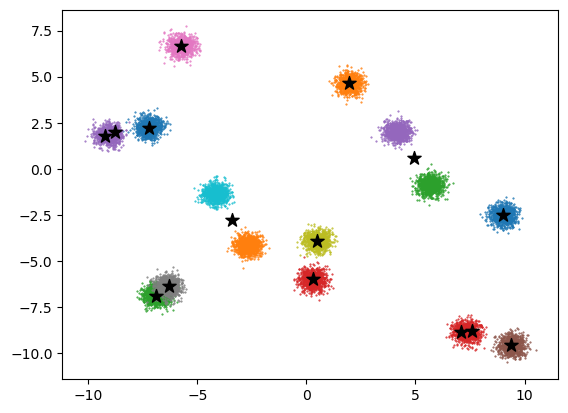

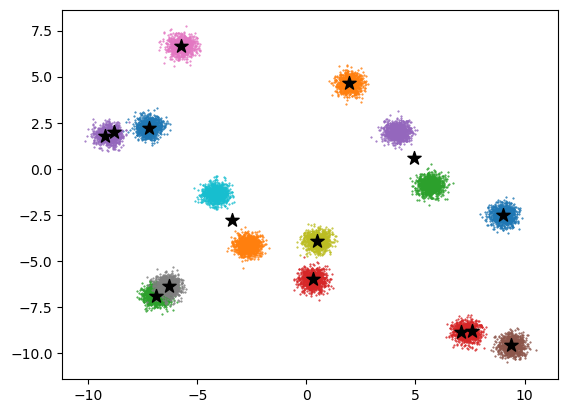

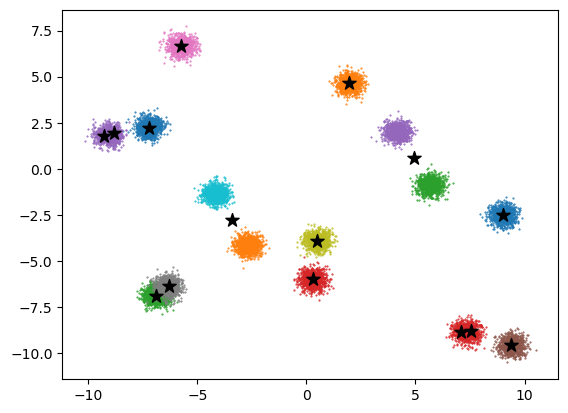

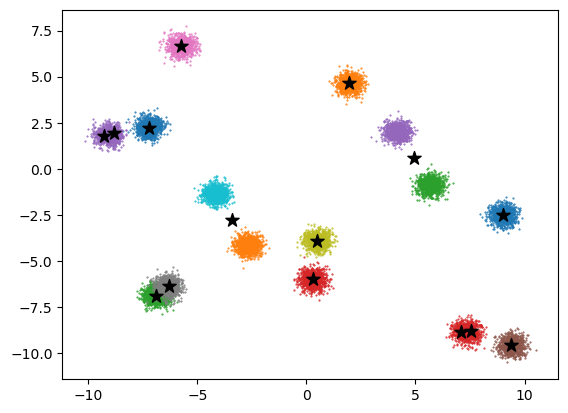

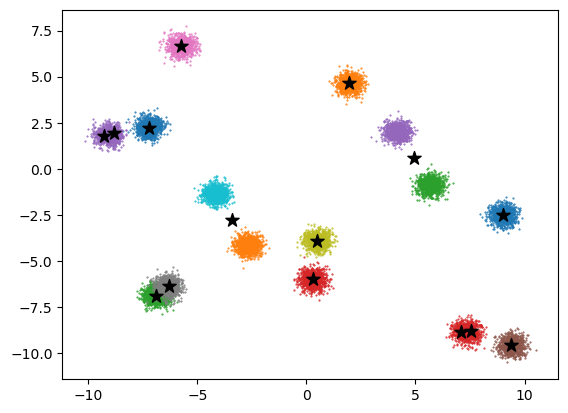

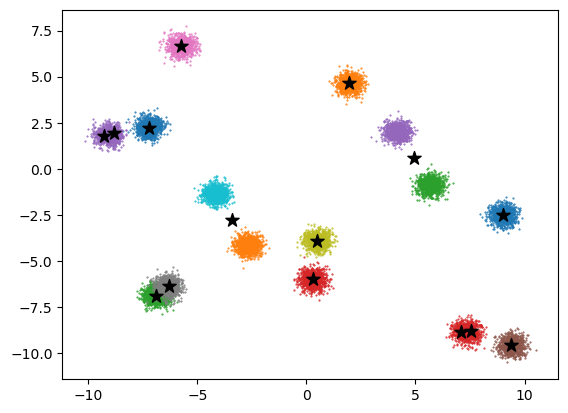

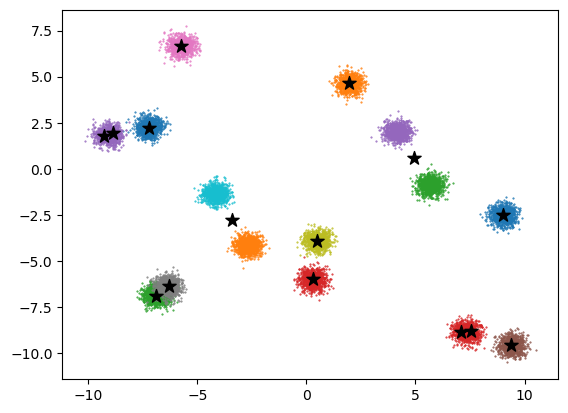

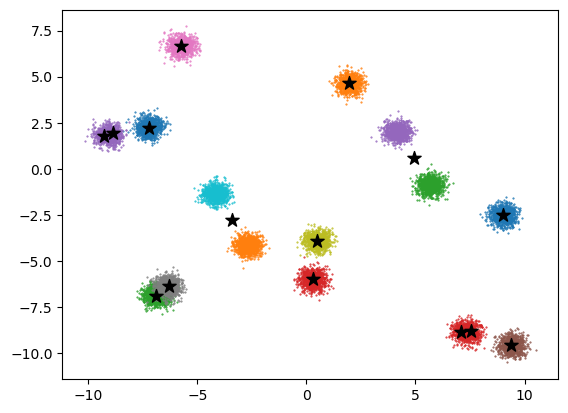

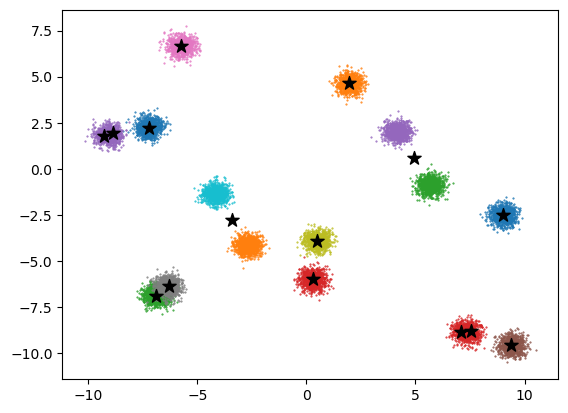

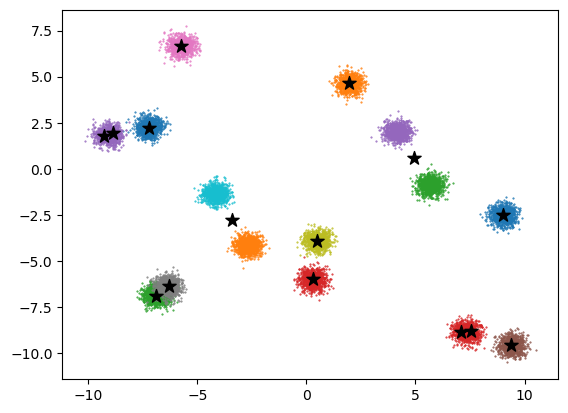

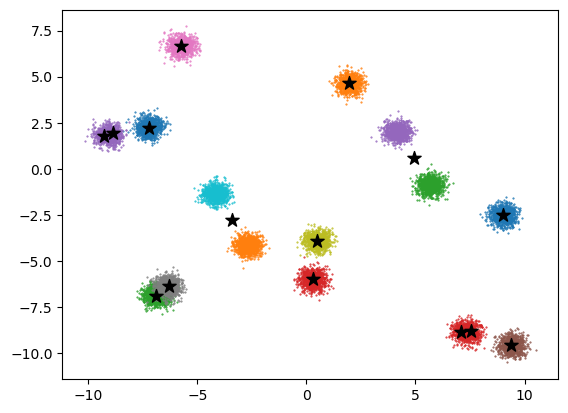

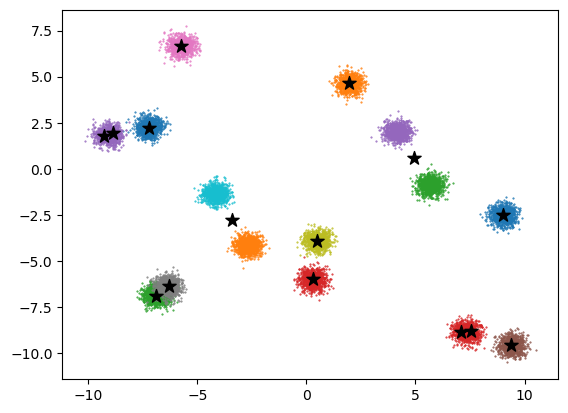

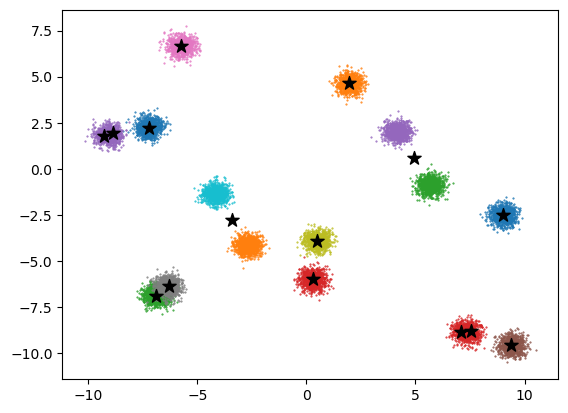

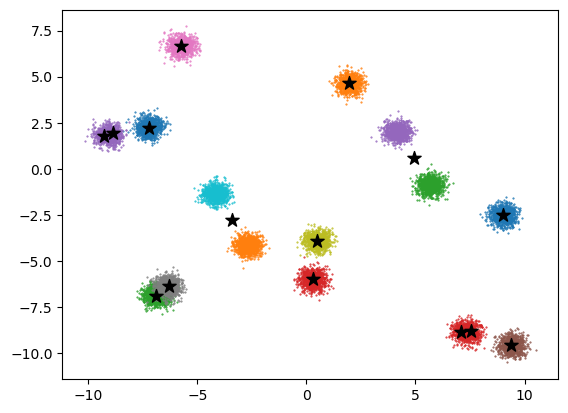

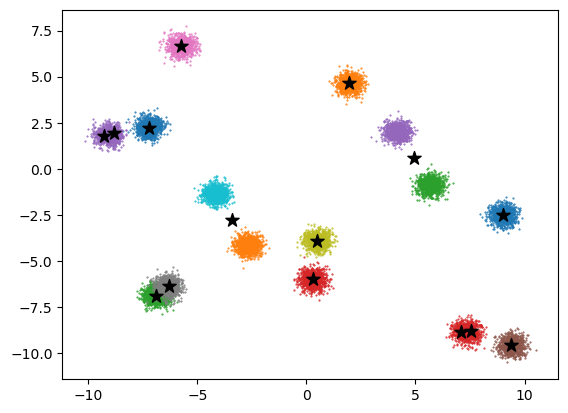

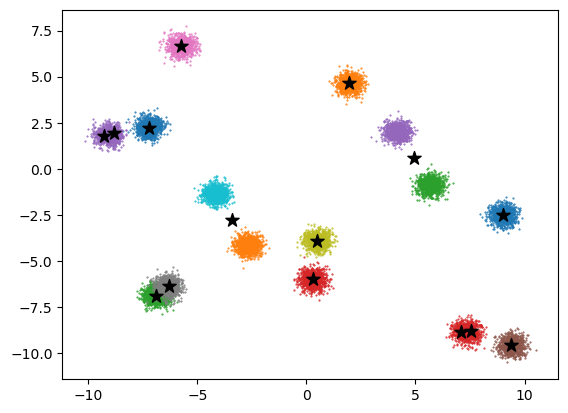

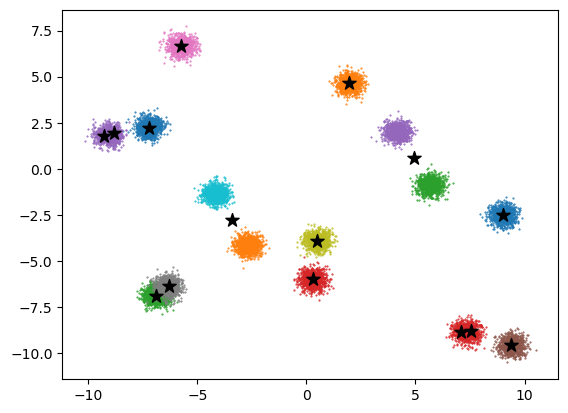

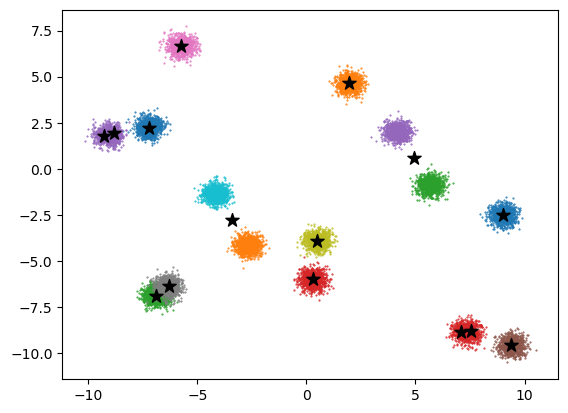

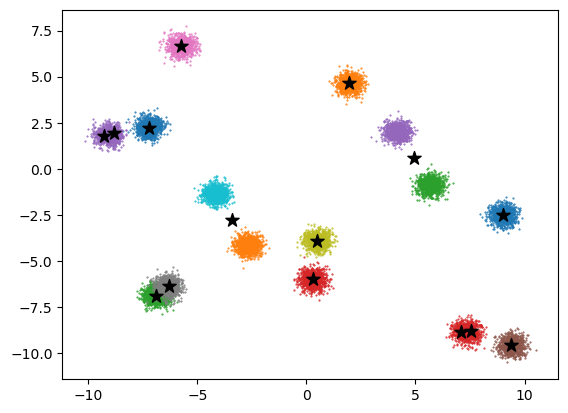

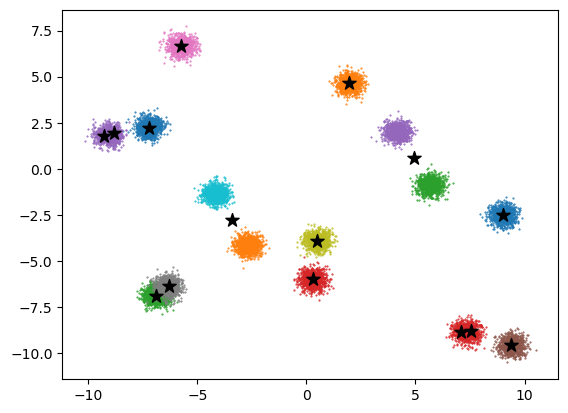

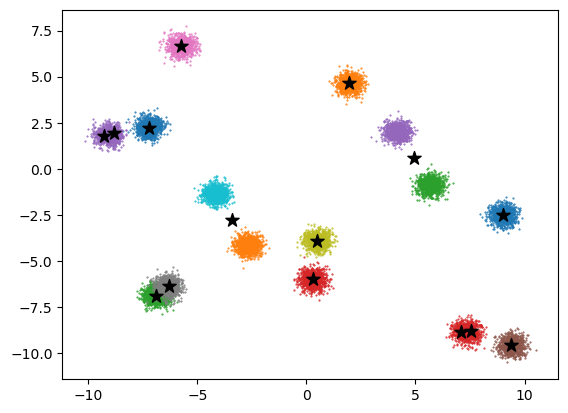

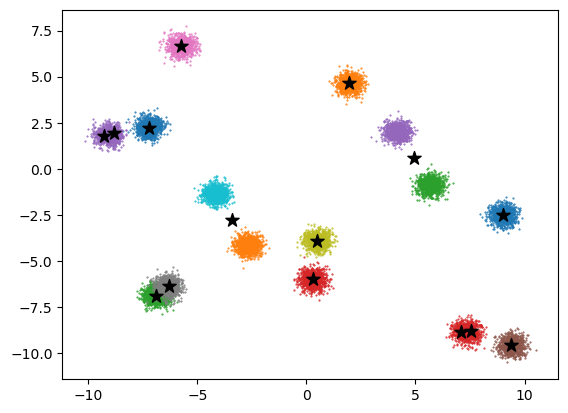

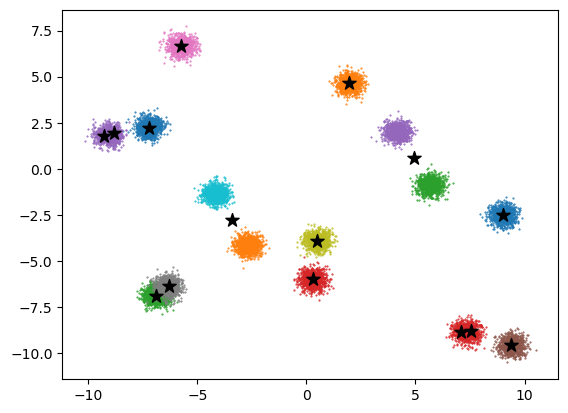

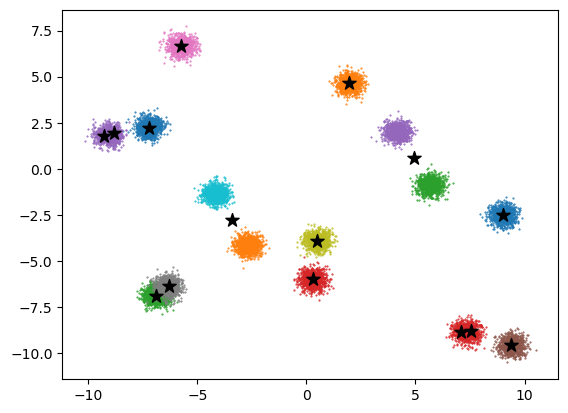

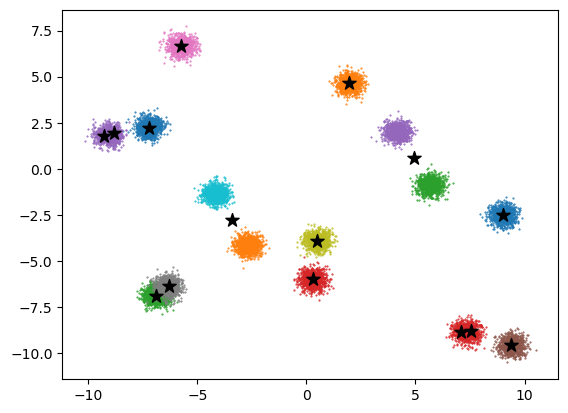

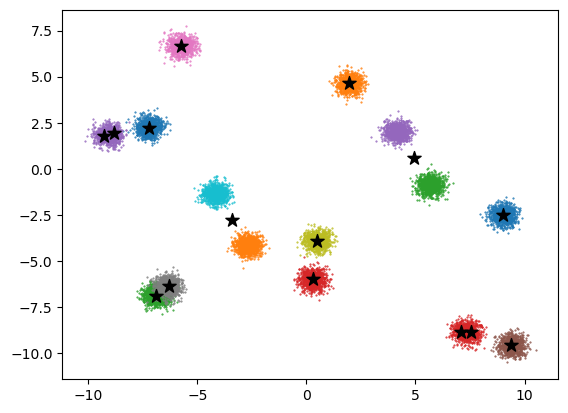

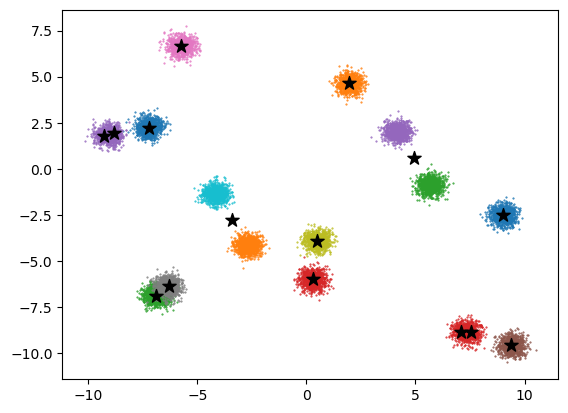

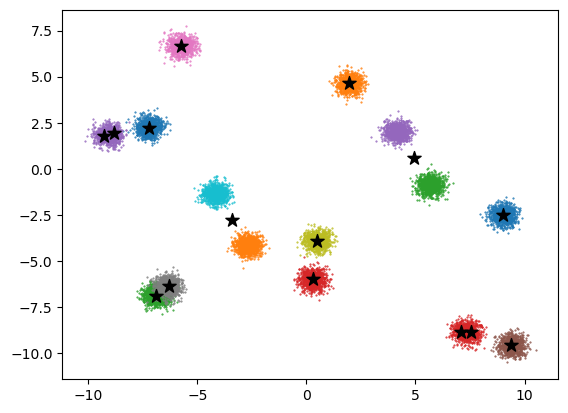

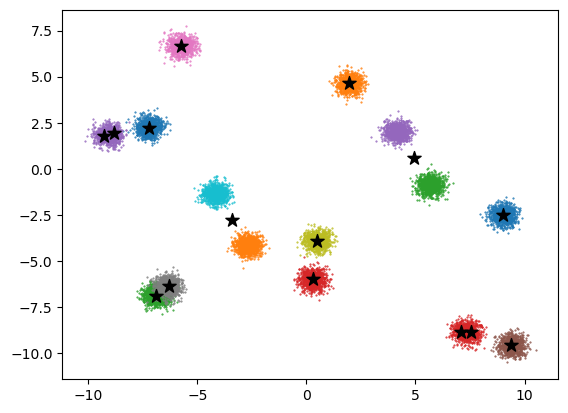

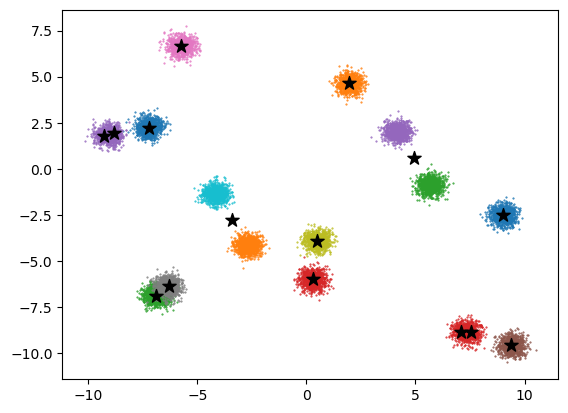

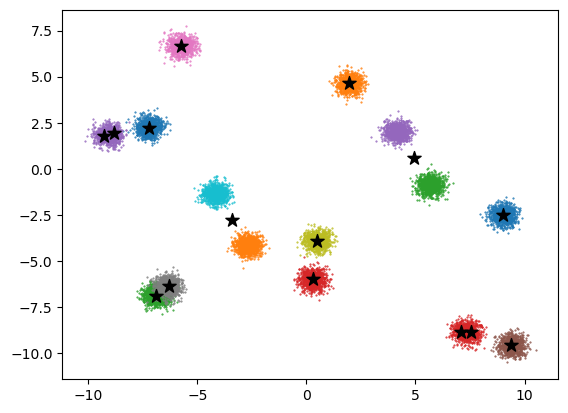

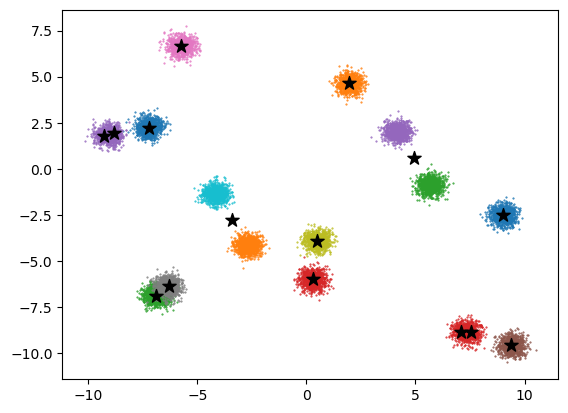

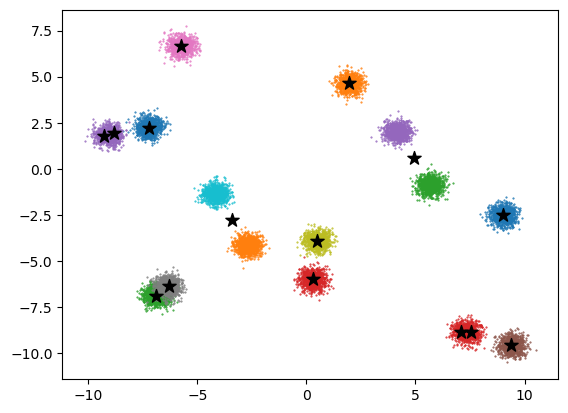

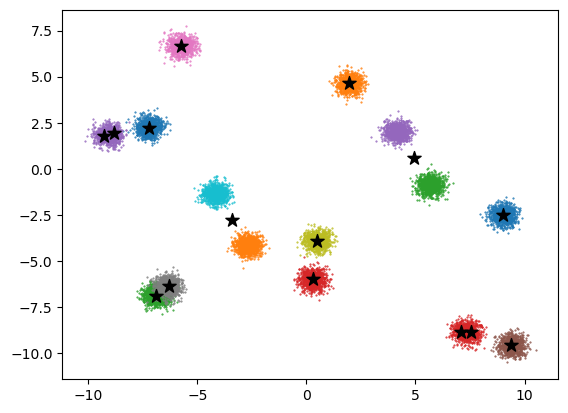

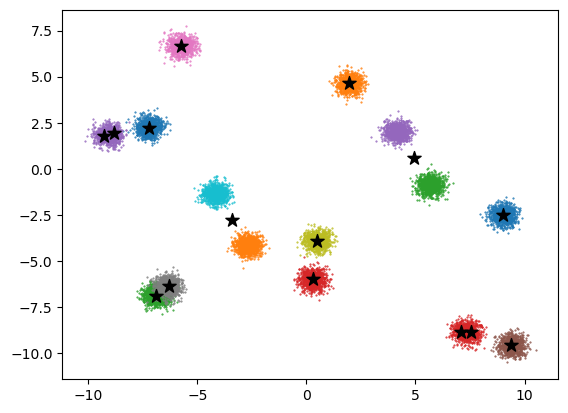

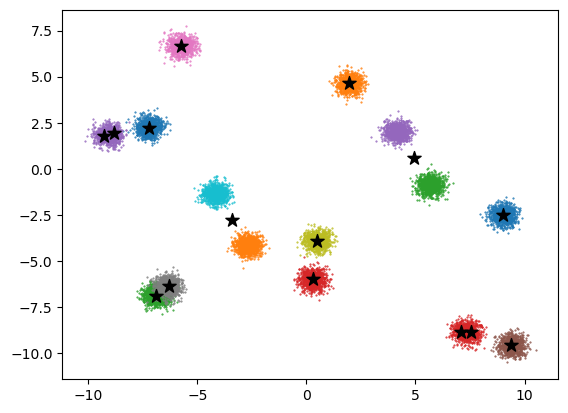

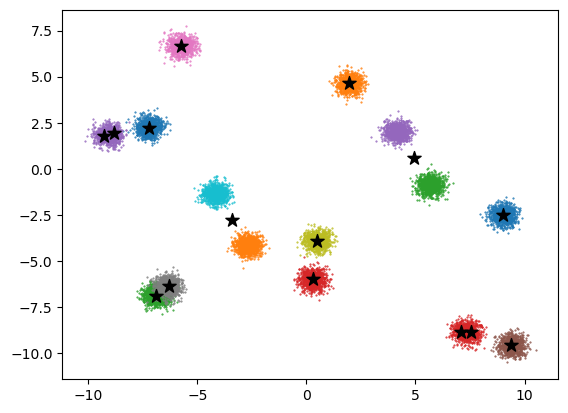

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [41]:
# hacky animation
from PIL import Image
# better spread out initalization
for p in range(10):
    torch.manual_seed(53532)
    centroids, assigned_clusters = kmeans(data, k, p, init_method='simple')
    plot_data(centroids, save = f'{p}')

In [43]:
imgs = [Image.open(f'{p}.png') for p in range(10)]
imgs[0].save("ani.gif", save_all=True, append_images=imgs[1:], duration=200, loop=0)

from IPython.display import Image as IPythonImage
IPythonImage(url='ani.gif')